In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import os
from collections import defaultdict
from time import time
from os import makedirs
from os.path import join, isdir
from glob import glob
from tensorflow.keras.callbacks import TensorBoard

sys.path.append('scripts')
from model_helpers import *
from data_helpers import *
from train_helpers import *

%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES']='1'

ModuleNotFoundError: No module named 'numpy'

In [ ]:
IMGS_PATH = r'G:\CO4001_eng_project\Datasets\mvtech_anomaly_detection\carpet\train\good'
OUT_PATH = r'saved\logs'

if not isdir(OUT_PATH):
    makedirs(OUT_PATH)

# Hyperparameters

In [ ]:
patch_size = (128, 128)
center_size = (32, 32)
num_train_test = num_test_test = 10
batch_size = 128
num_epochs = 500
model_width = 2

In [ ]:

# Glob for '*.jpg' files
files = glob(join(IMGS_PATH, '*.png'))

# Print the files to see what is being returned
print(f"Number of '*.jpg' files found: {len(files)}")
print(files)

Number of '*.jpg' files found: 280
['G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\000.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\001.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\002.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\003.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\004.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\005.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\006.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\007.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\008.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_anomaly_detection\\carpet\\train\\good\\009.png', 'G:\\CO4001_eng_project\\Datasets\\mvtech_an

# Load data

In [ ]:
files = np.random.choice(glob(join(IMGS_PATH, '*.png')), 100, replace=False)
train_files = files[ : -(num_train_test + num_test_test)]
train_test_files, test_test_files = files[-(num_train_test + num_test_test):-num_test_test], files[-num_test_test:]
fake_files = glob('data/fake_files/*.png')
fake_files = glob(r'G:\CO4001_eng_project\Datasets\mvtech_anomaly_detection\carpet\test\hole\*.png')


In [ ]:
print('Number of training files:', len(train_files))
print('Number of train-test files:', len(train_test_files))
print('Number of test-test files:', len(test_test_files))
print('Number of fake files:', len(fake_files))
imgss = defaultdict(list)
start = time()
for dataset, files in zip(['train', 'train_test', 'test_test', 'fake'], 
                          [train_files, train_test_files, test_test_files, fake_files]):
    for i, f in enumerate(files):
        imgss[dataset].append(cv2.imread(f, 0))
        if i % 1000 == 0 and i != 0:
            end = time()
            print('Processing dataset {}: {:.0f} sec - ETA: {:.0f} sec'.format(
                dataset, end-start, ((end-start) / (i + 1)) * (len(files) - i)))

Number of training files: 80
Number of train-test files: 10
Number of test-test files: 10
Number of fake files: 17


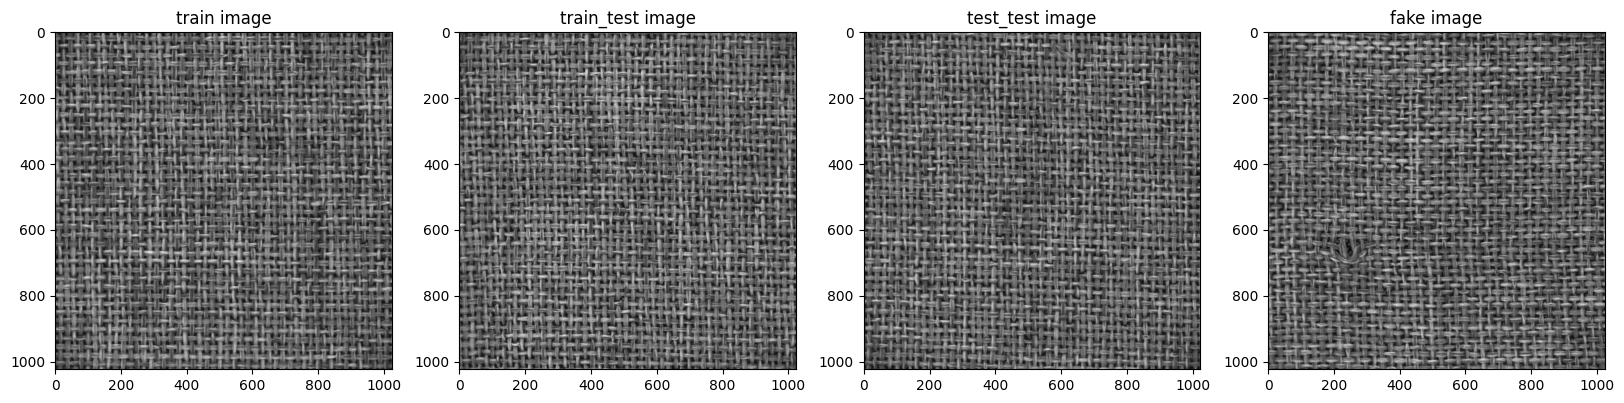

In [ ]:
fig, ax = plt.subplots(1, len(imgss.keys()), figsize=(20, 30))
for i, (dataset, imgs) in enumerate(imgss.items()):
    ax[i].imshow(imgs[0], 'gray')
    ax[i].set_title('{} image'.format(dataset))

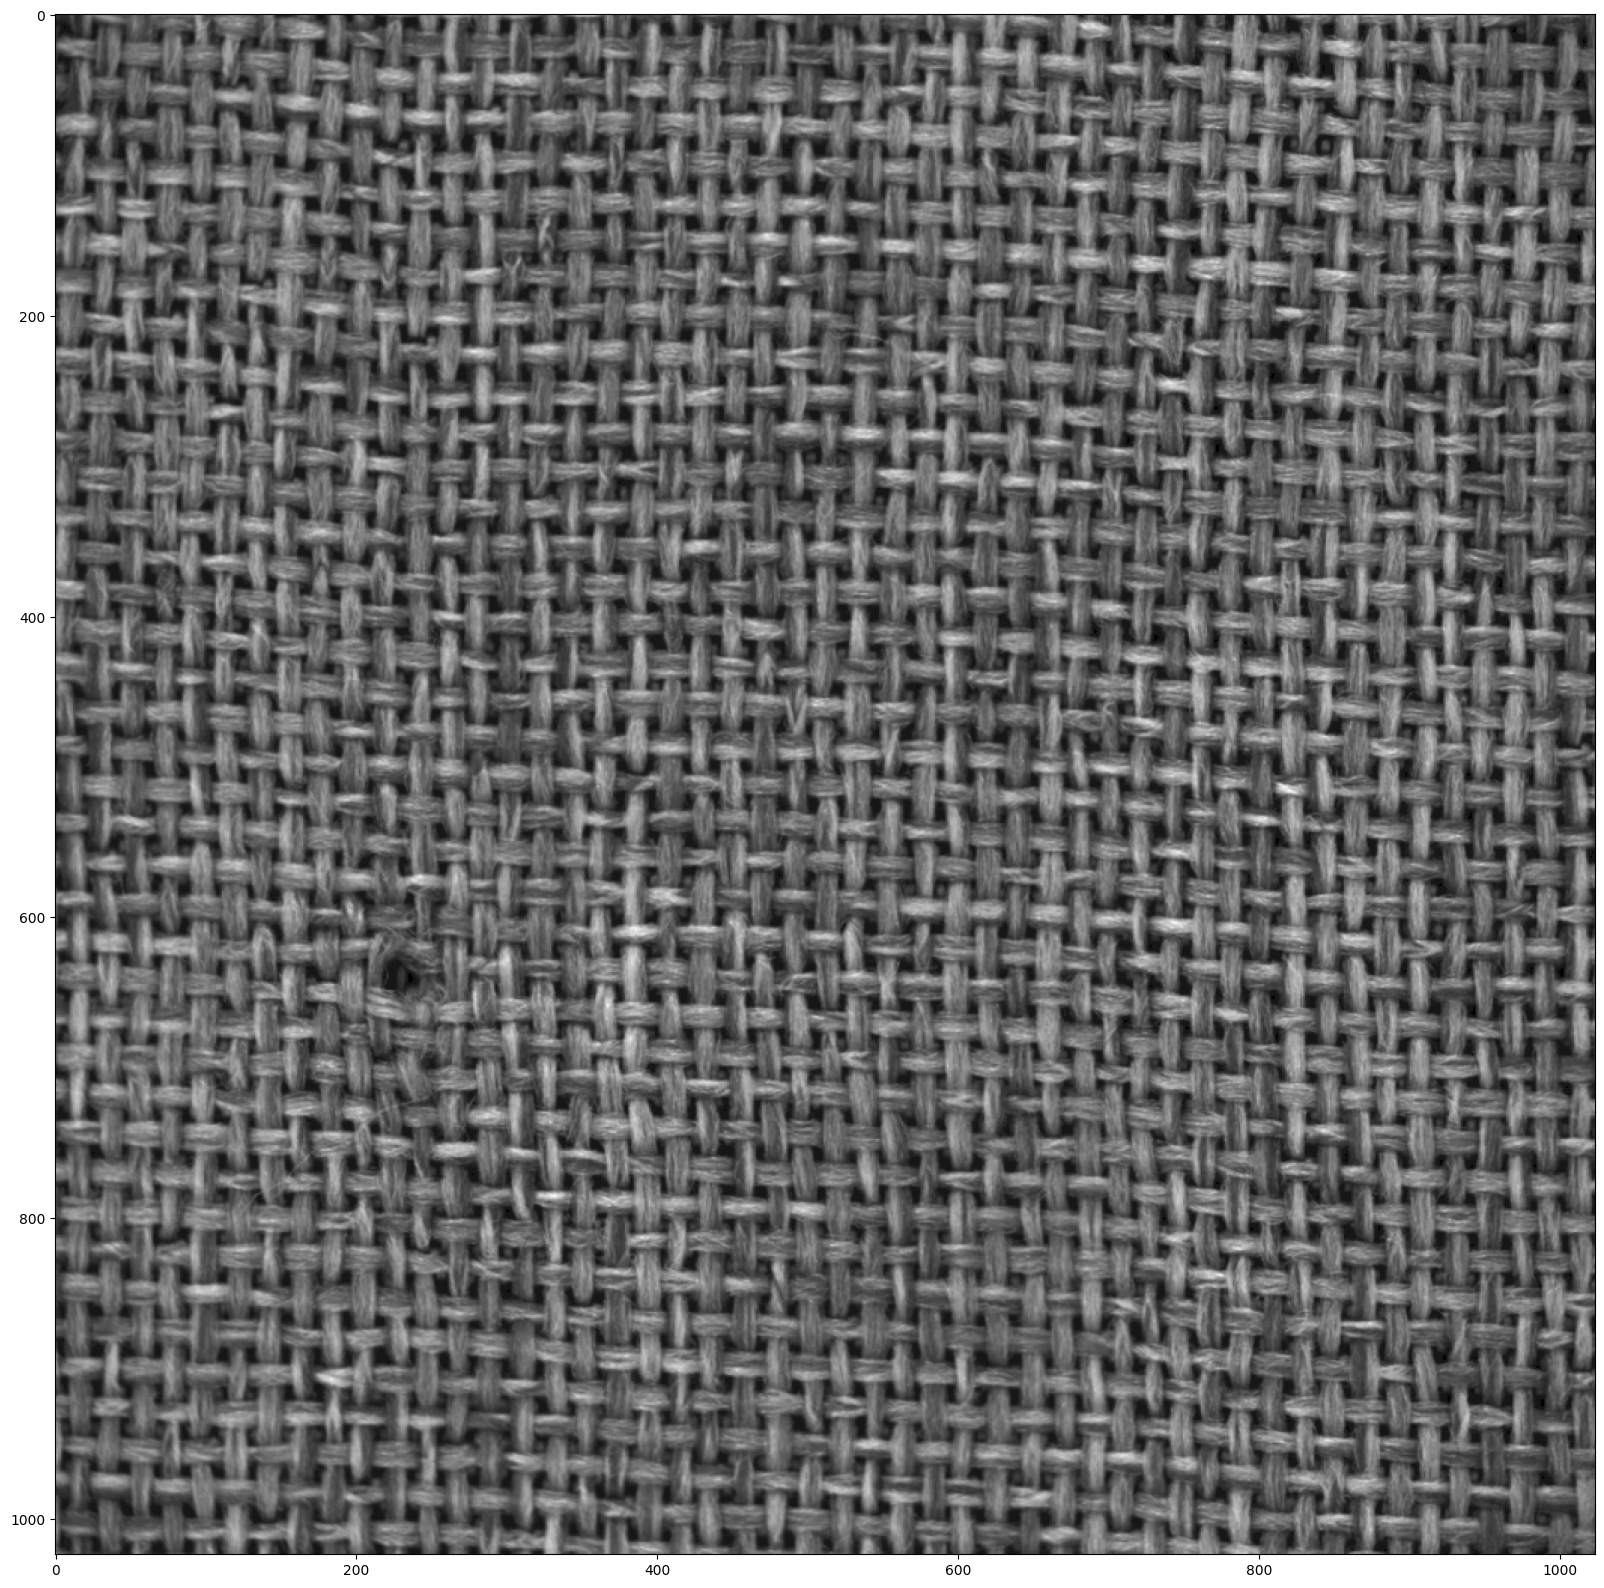

In [ ]:
plt.figure(figsize=(30, 20))
plt.imshow(imgss['fake'][1], 'gray')

## Square images and resize to same size

In [ ]:
for dataset, imgs in imgss.items():
    res_imgs = [img[:min(img.shape), :min(img.shape)] for img in imgs] 
    min_size = np.min([img.shape[0] for img in res_imgs])

    res_imgs = [cv2.resize(img, (min_size, min_size), interpolation=cv2.INTER_CUBIC) for img in res_imgs]
    imgss[dataset] = np.expand_dims(res_imgs, axis=3)

## Create training generator and evaluation images

In [ ]:
train_generator = DataGenerator(imgss['train'], patch_size, center_size, batch_size=batch_size, shuffle=True)

In [ ]:
x_test = []
for patches in patchess.values():
    x_test.extend(patches)
x_test = np.array(x_test)
print('x_test lenght:', len(x_test))

x_test lenght: 37


In [ ]:
mask = create_center_mask(patch_size, center_size)
patchess = defaultdict(list)
for i, (dataset, imgs) in enumerate(imgss.items()):
    if dataset != 'train':
        for j, img in enumerate(imgs):
            patchess[dataset].append(prepare_patch(img, patch_size, mask, i + j))

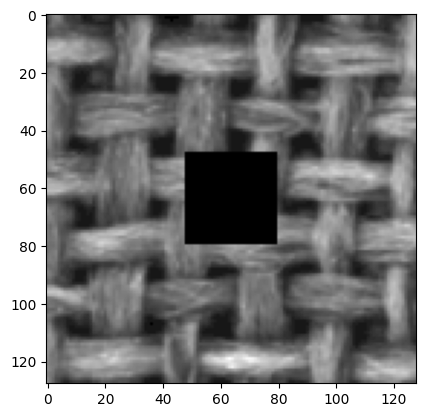

In [ ]:
plt.imshow(np.squeeze(patchess['fake'][3]), 'gray')

# Create model

In [ ]:
model = create_anomaly_cnn(model_width=model_width)

In [ ]:
model.patch_size = patch_size
model.center_size = center_size
model.batch_size = batch_size
model.num_epochs = num_epochs
model.model_width = model_width

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss=reconstruction_loss(patch_size, mask=mask), metrics=['accuracy'])

In [ ]:
images_callback = TensorBoardImages(OUT_PATH, patchess, vis_every=1)
checkpoint_callback = CustomModelCheckpoint(OUT_PATH, save_weights_only=False)
losses_callback = TensorBoard(log_dir=OUT_PATH, batch_size=batch_size)
print(f"hii: {images_callback}")

hii: <train_helpers.TensorBoardImages object at 0x0000024402BD8DD0>


In [ ]:
history_dict = model.fit(
                        train_generator, 
                        validation_data=(x_test, x_test),
                        epochs=2, 
                        verbose=1, 
                        callbacks=[images_callback, checkpoint_callback, losses_callback], 
                        workers=10, 
                        use_multiprocessing=True, 
                        shuffle=False, 
                        initial_epoch=0)

ValueError: Expected input data to be non-empty.